<div class="licence">
<span>Licence CC BY-NC-ND</span>
<span>Thierry Parmentelat</span>
</div>

# changements de variable

ou un vrai prétexte pour manipuler les objets fonctionnels en tant que valeurs

ce notebook élabore autour du projet numérique "tracé du contour"

## rappel

dans le projet numérique qui vise à calculer les lignes de niveau d'une fonction, on vous suggère

* de traiter avec `simple_contour` le cas très spécifique 
  * d'une fonction définie sur le pavé unité $[0..1]^2$,
  * et avec une courbe qui "entre par le bord gauche" (x=0)
* puis de généraliser avec `contour` en découpant un domaine quelconque en pavés élémentaires

## notre sujet

nous allons étudier les transformations qui permettent de passer du cas général au cas spécifique

soit donc $f : [x1 .. x2] \times [y1 .. y2] \longrightarrow \mathbb{R}$

pour se ramener à une fonction qui vérifie les hypothèses de `simple_contour`, on voit qu'il s'agit de déformer le domaine de manière linéaire de sorte que le pavé  
$[x1 .. x2] \times [y1 .. y2]$ corresponde à $[0..1]^2$.

et comme `simple_contour` fait l'hypothèse que le contour commence sur le bord gauche, on va envisager aussi les 4 rotations du pavé

## comment s'y prendre

on commence par coder les changements de variable élémentaires qui correspondent 

* aux translations
* aux homothéties (scaling)
* aux rotations autour du point (0.5, 0.5)

### translations

le changement de variable le plus élémentaire est la translation:

en partant de la fonction $f : \mathbb{R}^2 \longrightarrow \mathbb{R}$ et étant donné deux réels $(x_0,y_0)$, on peut facilement dériver une fonction $f_{t(x_0,y_0)}$ qui correspond à $f$ translatée de $(x_0, y_0)$ par

$f_{t(x_0,y_0)}(x, y) = f(x-x_0, y-y_0)$

on peut très facilement coder la fonction `translate` en Python :

In [1]:
# en entrée f est une fonction R2->R
def translate(f, x0, y0):
    def translated(x, y):
        return f(x-x0, y-y0)
    # en sortie on veut aussi une fonction R2->R
    return translated

si on voulait décrire formellement la fonction translate, on écrirait

$translate: {\mathbb{R}}^{\mathbb{R}^2} \times \mathbb{R}^2\longrightarrow {\mathbb{R}}^{\mathbb{R}^2}$

qui est une façon très pédante de dire le fait très simple que

 
* si on a en entrée
  * une fonction $f: \mathbb{R}^2 \longrightarrow \mathbb{R}$
  * et deux réels
* alors on aura en sortie
  * une nouvelle fonction $\mathbb{R}^2 \longrightarrow \mathbb{R}$

on peut écrire exactement la même chose en utilisant une lambda

In [2]:
def translate(f, x0, y0):
    def translated(x, y):
        return f(x-x0, y-y0)
    return translated

In [3]:
# c'est totalement équivalent 
# d'écrire
def translate(f, x0, y0):
    return lambda x, y: f(x-x0, y-y0)

#### visualisation

on va visualiser une fonction, disons reconnaissable

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# attention à bien importer le numpy d'autograd ici
import autograd.numpy as np

In [5]:
def gaussian(x, y):
    """
    centered gaussian on X, Y
    not normalized,
    i.e. gaussian(0, 0) = 1
    """
    return np.exp(-x**2 -y**2)

In [6]:
def h(x, y):
    return 2*(gaussian(x, y) 
              - gaussian(x-1, y-1))

In [7]:
# le maximum est ici
h(0, 0)

1.7293294335267746

In [8]:
# le domaine de visualisation
X = np.arange(-4, 4, 0.25)
Y = np.arange(-4, 4, 0.25)
X, Y = np.meshgrid(X, Y)

In [9]:
def show_3d(X, Y, Z, sizex=6, sizey=6):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')
    ax.plot_surface(
        X, Y, Z, cmap=cm.coolwarm,
        linewidth=0, antialiased=False);

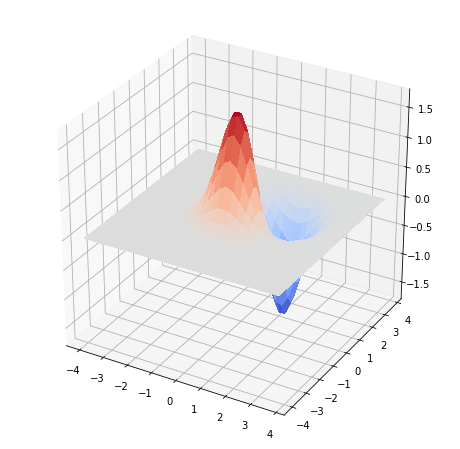

In [10]:
Z = h(X, Y)
show_3d(X, Y, Z)

In [11]:
# on fabrique la fonction translatée
translated_h = translate(h, 1, 2)

In [12]:
# le maximum doit être ici
translated_h(1, 2)

1.7293294335267746

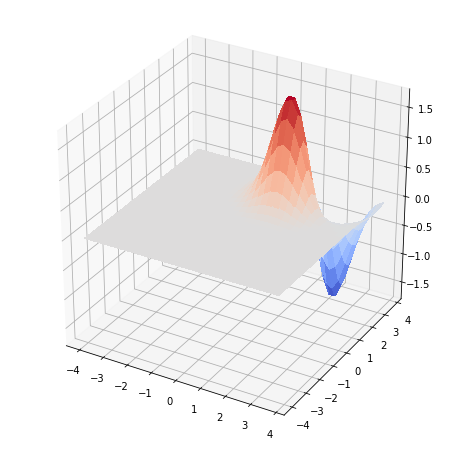

In [13]:
Z2 = translated_h(X, Y)

show_3d(X, Y, Z2)

### changement d'échelle

on s'y prend de manière similaire pour les déformations d'étirement

In [14]:
def scale(f, sx, sy):
    def scaled(x, y):
        return f(x/sx, y/sy)
    return scaled

In [15]:
def scale(f, sx, sy):
    return lambda x, y: f(x/sx, y/sy)

In [16]:
scaled_h = scale(h, 3, 2)

In [17]:
# maximum inchangé
scaled_h(0, 0)

1.7293294335267746

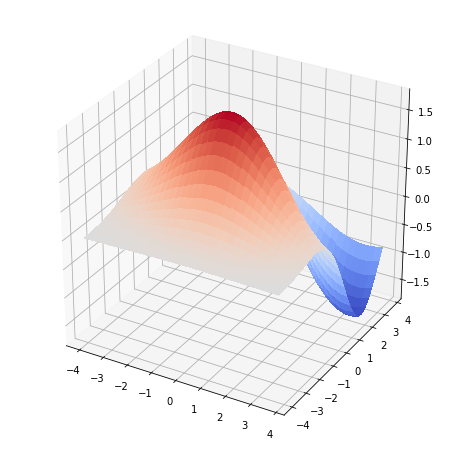

In [18]:
Z3 = scaled_h(X, Y)

show_3d(X, Y, Z3)

### rotations

on commence par se définir les 4 rotations

In [19]:
from enum import IntEnum

class Angle(IntEnum):
    LEFT = 0      # no rotation
    TOP = 1       # rotate π/2 counter-clockwise around (0.5, 0.5)
    RIGHT = 2     # rotate π around around (0.5, 0.5)
    BOTTOM = 3    # rotate π/2 clockwise around (0.5, 0.5)
    
    @classmethod
    def ALL(cls):
        return (Angle(i) for i in range(4))

    # on pourrait avoir besoin d'inverser
    def __neg__(self):
        return Angle((4-self)%4)
    
    def rotate(self, x, y):
        """x, y -> x, y"""
        if self == Angle.LEFT:
            return (x, y)
        if self == Angle.TOP:
            return (y, 1-x)
        if self == Angle.RIGHT:
            return (1-x, 1-y)
        if self == Angle.BOTTOM:
            return (1-y, x)
        

In [20]:
x = Angle.TOP
y = -x

In [21]:
x, y

(<Angle.TOP: 1>, <Angle.BOTTOM: 3>)

In [22]:
# cette fonction globale (ne pas confondre avec Angle.rotate)
# est une usine à fonctions comme translate() et scale()
def rotate(f, angle: Angle):
    return lambda x, y: f(*angle.rotate(x, y))


In [23]:
# on focalise sur le carré unité
X1 = np.arange(0, 1, .1)
Y1 = np.arange(0, 1, .1)
X1, Y1 = np.meshgrid(X1, Y1)

Zh = h(X1, Y1)

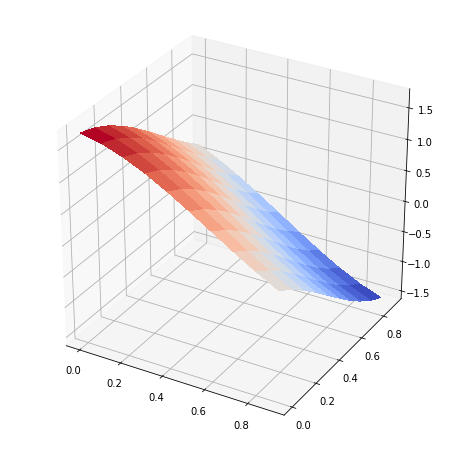

In [24]:
show_3d(X1, Y1, Zh)

In [25]:
# identique à h en principe
h_l = rotate(h, Angle.LEFT)

Zl = h_l(X1, Y1)

In [26]:
# tourné d'un quart ⤿
h_t = rotate(h, Angle.TOP)

Zt = h_t(X1, Y1)

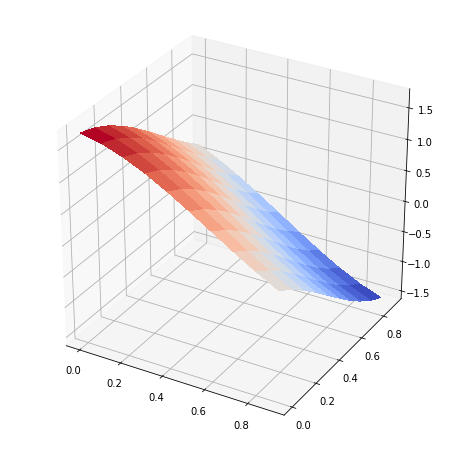

In [27]:
show_3d(X1, Y1, Zl)

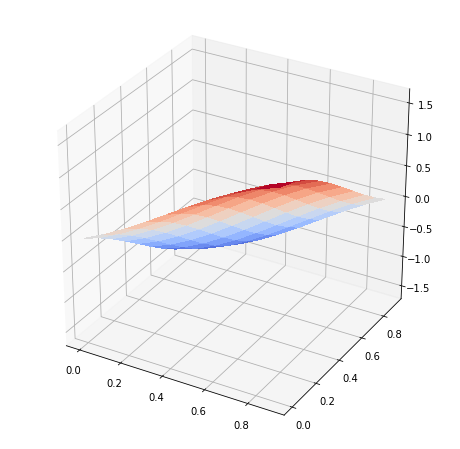

In [28]:
show_3d(X1, Y1, Zt)

In [29]:
# demi tour
h_r = rotate(h, Angle.RIGHT)

Zr = h_r(X1, Y1)

In [30]:
# 1/4 de tour ⤾
h_b = rotate(h, Angle.BOTTOM)

Zb = h_b(X1, Y1)

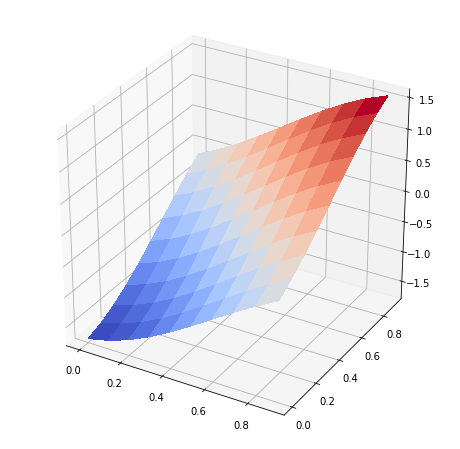

In [31]:
show_3d(X1, Y1, Zr)

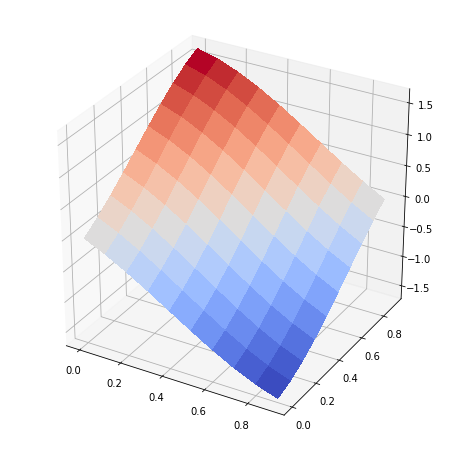

In [32]:
show_3d(X1, Y1, Zb)

In [33]:
# imaginons que vous avez déjà écrit simple_contour
from contour import simple_contour

In [34]:
# pour voir comment l'appeler
# simple_contour?

/Users/tparment/miniconda3/envs/flotpython-slides/lib/python3.7/site-packages/autograd/numpy/numpy_wrapper.py:66: UserWarning: r_ is slow for array inputs. np.concatenate() is faster.
  "np.concatenate() is faster.".format(slow_op_name))


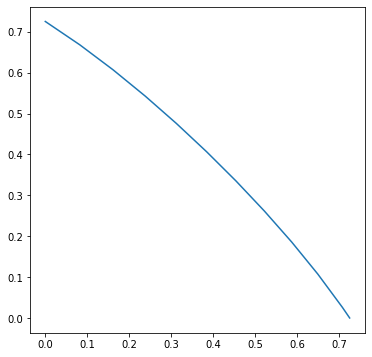

In [35]:
X, Y = simple_contour(h, 0.5)

plt.figure(figsize=(6, 6))
plt.plot(X, Y);

In [36]:
# alors pour écrire la fonction coutour complète on peut utiliser nos outils

import itertools

def contour(f, c, xs, ys, delta):
    
    curves = []
    
    identity = lambda x, y: (x, y)

    nx, ny = len(xs), len(ys)
    for i, j in itertools.product(range(nx-1), range(ny-1)):
        x1, x2 = xs[i], xs[i+1]
        y1, y2 = ys[j], ys[j+1]

        for angle in Angle.ALL():
            # here we build the function suitable for simple_contour
            f_cell = rotate(scale(translate(f, -x1, -y1), 1/(x2-x1), 1/(y2-y1)), angle)
            
            # these are relative to the unit square
            X_01, Y_01 = simple_contour(f_cell, c, delta=delta)
            
            # nothing found
            if len(X_01) ==0:
                continue
                
            # so we need to remap them into the [x1, x2] x [y1, y2] domain
            # which amounts to reversing the deformation from f to f_cell
            X, Y = [], []
            for x_01, y_01 in zip(X_01, Y_01):
                # it's possible to undo one level using rotate applied on identity
                rx, ry = rotate(identity, angle)(x_01, y_01)
                # the other moves we must apply by hand 
                # cannot use the scale/translate thing here - discussion..
                sx, sy = (x2-x1)*rx, (y2-y1)*ry
                tx, ty = sx + x1, sy + y1
                X.append(tx), Y.append(ty)
            curves.append((X, Y))
                
    return curves

In [37]:
def draw_contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.1):
    curves = contour(f, c, xs, ys, delta)
    for X, Y in curves:
        plt.plot(X, Y)

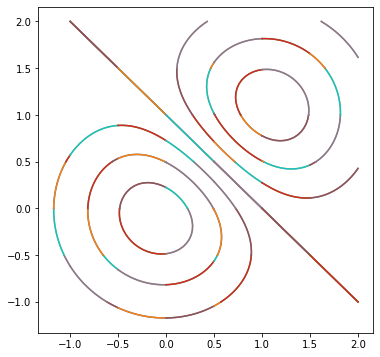

In [38]:
plt.figure(figsize=(6, 6))

# upper bound not included in arange
steps = np.arange(-2, +2.0001, 0.5)

for c in np.arange(-1.5, 1.5001, .5):
    draw_contour(h, c, steps, steps)